In [24]:
import torch
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, GINConv, SAGEConv
from torch_geometric.datasets import Planetoid

## 选题A，Message Passing实验分析

## 定义模型
GCN、GAT、GIN、GraphSAGE

控制变量
- 均为双层网络，整体架构和隐层维度均一致
- 激活函数ReLU和dropout比例均一致

In [25]:
class GCN(torch.nn.Module):
    def __init__(self, in_channel, out_channel):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channel, 32)
        self.conv2 = GCNConv(32, out_channel)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)

        return x

class GAT(torch.nn.Module):
    def __init__(self, in_channel, out_channel):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channel, 32)
        self.conv2 = GATConv(32, out_channel)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)

        return x

class GIN(torch.nn.Module):
    def __init__(self, in_channel, out_channel):
        super(GIN, self).__init__()
        self.ff1 = torch.nn.Linear(in_channel, 32)
        self.conv1 = GINConv(self.ff1)
        self.ff2 = torch.nn.Linear(32, out_channel)
        self.conv2 = GINConv(self.ff2)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)

        return x

class SAGE(torch.nn.Module):
    def __init__(self, in_channel, out_channel):
        super(SAGE, self).__init__()
        self.conv1 = SAGEConv(in_channel, 32)
        self.conv2 = SAGEConv(32, out_channel)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)

        return x

## 定义训练与测试函数

控制变量
- 使用的训练优化器参数设定均一致
- 训练轮数一致

In [26]:
def train(model, data, device='cuda'):
    model = model.to(device)
    data = data.to(device)
    
    losses = []
    accs = []

    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    loss_fn = torch.nn.CrossEntropyLoss()
    
    for epoch in tqdm(range(200)):
        model.train()
        logits = model(data)
        optimizer.zero_grad()
        loss = loss_fn(logits[data.train_mask], data.y[data.train_mask])
        loss.backward()
        losses.append(loss.item())
        optimizer.step()

        if (epoch + 1) % 5 == 0:
            accs.append(test(model, data, device))

    return losses, accs

def test(model, data, device='cuda'):
    model.eval()
    model = model.to(device)
    data = data.to(device)
    with torch.no_grad():
        _, pred = model(data).max(dim=1)
        correct = pred[data.test_mask].eq(data.y[data.test_mask]).sum()
        acc = correct / data.test_mask.sum()
    return acc.item()

## 在Cora上进行实验

训练集和测试集重新划分为5:5

In [27]:
dataset = Planetoid('./data', 'Cora')
data = dataset[0]
N_train = data.x.shape[0] * 5 // 10
all_samples = list(range(data.x.shape[0]))
random.shuffle(all_samples)
train_samples = all_samples[:N_train]
test_samples = all_samples[N_train:]
data.train_mask *= False
data.train_mask[train_samples] = True
data.test_mask *= False
data.test_mask[test_samples] = True

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
in_channels = data.num_node_features
out_channels = dataset.num_classes

In [29]:
GCNmodel = GCN(in_channels, out_channels)
GCNlosses, GCNaccs = train(GCNmodel, data, device)
GCNacc = test(GCNmodel, data, device)

100%|██████████| 200/200 [00:00<00:00, 225.83it/s]


In [30]:
GATmodel = GAT(in_channels, out_channels)
GATlosses, GATaccs = train(GATmodel, data, device)
GATacc = test(GATmodel, data, device)

100%|██████████| 200/200 [00:00<00:00, 218.24it/s]


In [31]:
GINmodel = GIN(in_channels, out_channels)
GINlosses, GINaccs = train(GINmodel, data, device)
GINacc = test(GINmodel, data, device)

100%|██████████| 200/200 [00:00<00:00, 404.40it/s]


In [32]:
SAGEmodel = SAGE(in_channels, out_channels)
SAGElosses, SAGEaccs = train(SAGEmodel, data, device)
SAGEacc = test(SAGEmodel, data, device)

100%|██████████| 200/200 [00:00<00:00, 396.54it/s]


训练loss曲线对比

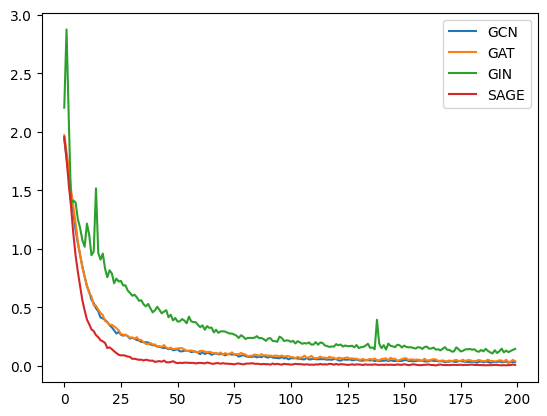

In [33]:
plt.plot(GCNlosses, label='GCN')
plt.plot(GATlosses, label='GAT')
plt.plot(GINlosses, label='GIN')
plt.plot(SAGElosses, label='SAGE')
plt.legend()
plt.show()

测试ACC曲线对比

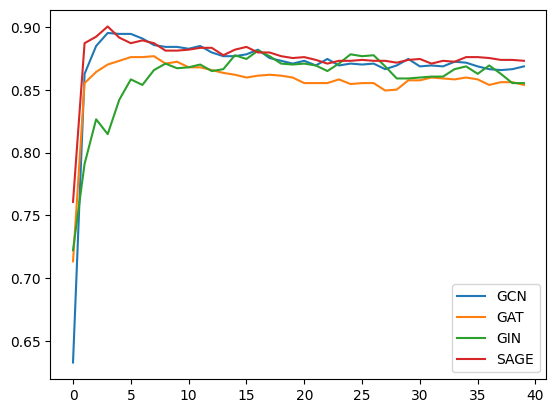

In [34]:
plt.plot(GCNaccs, label='GCN')
plt.plot(GATaccs, label='GAT')
plt.plot(GINaccs, label='GIN')
plt.plot(SAGEaccs, label='SAGE')
plt.legend()
plt.show()

## 在Pubmed上进行实验

训练集和测试集重新划分为5:5

In [35]:
dataset = Planetoid('./data', 'Cora')
data = dataset[0]
N_train = data.x.shape[0] * 5 // 10
all_samples = list(range(data.x.shape[0]))
random.shuffle(all_samples)
train_samples = all_samples[:N_train]
test_samples = all_samples[N_train:]
data.train_mask *= False
data.train_mask[train_samples] = True
data.test_mask *= False
data.test_mask[test_samples] = True

In [36]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
in_channels = data.num_node_features
out_channels = dataset.num_classes

In [37]:
GCNmodel = GCN(in_channels, out_channels)
GCNlosses, GCNaccs = train(GCNmodel, data, device)
GCNacc = test(GCNmodel, data, device)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 342.49it/s]


In [38]:
GATmodel = GAT(in_channels, out_channels)
GATlosses, GATaccs = train(GATmodel, data, device)
GATacc = test(GATmodel, data, device)

100%|██████████| 200/200 [00:01<00:00, 181.18it/s]


In [39]:
GINmodel = GIN(in_channels, out_channels)
GINlosses, GINaccs = train(GINmodel, data, device)
GINacc = test(GINmodel, data, device)

100%|██████████| 200/200 [00:00<00:00, 332.82it/s]


In [40]:
SAGEmodel = SAGE(in_channels, out_channels)
SAGElosses, SAGEaccs = train(SAGEmodel, data, device)
SAGEacc = test(SAGEmodel, data, device)

100%|██████████| 200/200 [00:00<00:00, 338.91it/s]


训练loss曲线对比

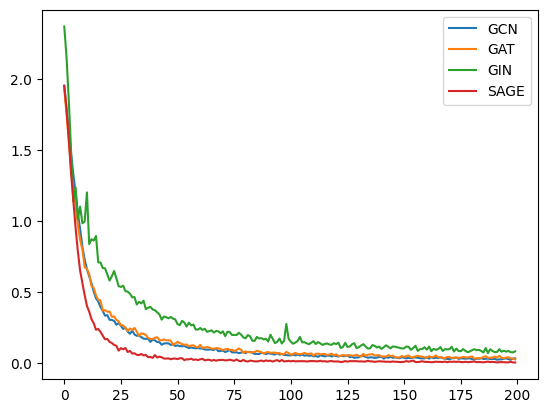

In [41]:
plt.plot(GCNlosses, label='GCN')
plt.plot(GATlosses, label='GAT')
plt.plot(GINlosses, label='GIN')
plt.plot(SAGElosses, label='SAGE')
plt.legend()
plt.show()

测试ACC曲线对比

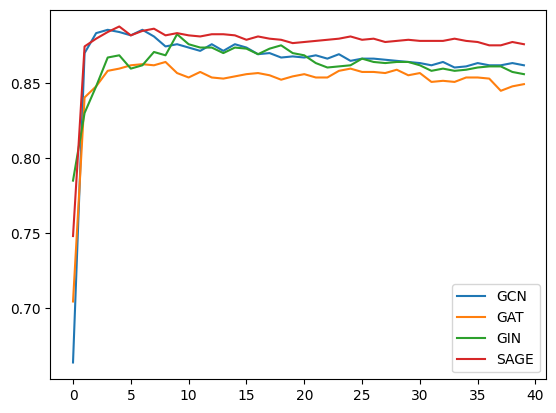

In [42]:
plt.plot(GCNaccs, label='GCN')
plt.plot(GATaccs, label='GAT')
plt.plot(GINaccs, label='GIN')
plt.plot(SAGEaccs, label='SAGE')
plt.legend()
plt.show()

结果，在这次实验中，从loss的下降速度来看
- GraphSAGE收敛效果最好
- GIN收敛效果最慢，且收敛过程较为不稳定
- GAT和GCN效果几乎一致，但GAT的ACC表现不如GCN

## 补充实验：GIN的聚集函数的影响

In [43]:
class GINnew(torch.nn.Module):
    def __init__(self, in_channel, out_channel):
        super(GINnew, self).__init__()
        self.ff1 = torch.nn.Sequential(
            torch.nn.Linear(in_channel, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 32),
        )
        self.conv1 = GINConv(self.ff1)
        self.ff2 = torch.nn.Sequential(
            torch.nn.Linear(32, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, out_channel),
        )
        
        self.conv2 = GINConv(self.ff2)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)

        return x

In [44]:
GINnewmodel = GINnew(in_channels, out_channels)
GINnewlosses, GINnewaccs = train(GINnewmodel, data, device)
GINnewacc = test(GINnewmodel, data, device)

100%|██████████| 200/200 [00:00<00:00, 304.60it/s]


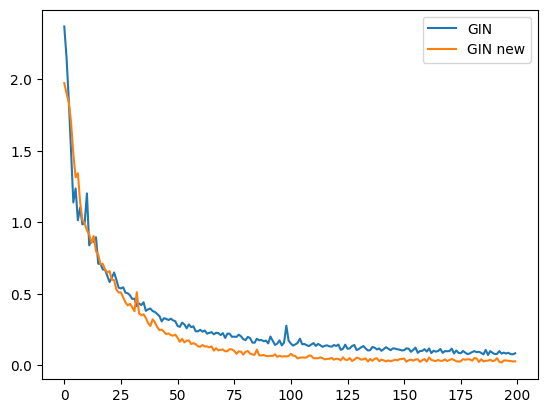

In [45]:
plt.plot(GINlosses, label='GIN')
plt.plot(GINnewlosses, label='GIN new')
plt.legend()
plt.show()

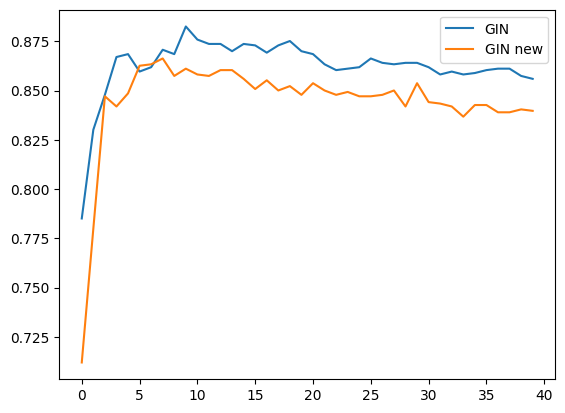

In [46]:
plt.plot(GINaccs, label='GIN')
plt.plot(GINnewaccs, label='GIN new')
plt.legend()
plt.show()

结果，改进聚集函数，虽然使得loss下降更快，但也因增加了参数量，可能在Pubmed这个较小的数据集上产生了过拟合，导致性能不如原来简单的GIN